# Risk Parity Investment Strategy
## Use Index of representative asset classes
#### Developed-Emerging Equity, Real Estate, Commmodity, Treasury, Corporate Bond, TIPS are included
### Resuld is driven from 2010 to 2021 market data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np
import pandas as pd
import quantstats
from scipy.optimize import minimize

from utils.index_data import index_data
from utils.yahoo_stock_data import yahoo_data
from utils.regular_rebalancing import rp_rebalance_strategy

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

#### Load Data of each asset classes
#### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [4]:
data_setting = {
    'start' : '2010-01-01',
    'end' : '2021-06-30',
    'rebal_period':'1M'
}

data = index_data(**data_setting)
yield_df = data.index_data_loading()

bm_class_ticker =[
    "VTI", # Vanguard Total Stock Market ETF                        2001-05-24
    "TLT", # iShares 20+ Year Treasury Bond ETF                     2002-07-22
    "IEI", # iShares 3-7 Year Treasury Bond ETF                     2007-01-05
    "GLD", # SPDR Gold Trust                                        2004-11-18
    "GSG"  # iShares S&P GSCI Commodity Indexed Trust               2006-07-10
                    ]
# to draw benchmark
data_setting = {
    'start' : '2010-01-01',
    'end' : '2021-06-30',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1M',
}

data = yahoo_data(**data_setting)
benchmark_yield_df = data.yahoo_stock_data_loading()
benchmark_yield_df['BM'] = (0.3*benchmark_yield_df.loc[:,'VTI'] +
                            0.4*benchmark_yield_df.loc[:,'TLT'] +
                            0.15*benchmark_yield_df.loc[:,'IEI'] +
                            0.075*benchmark_yield_df.loc[:,'GLD'] +
                            0.075*benchmark_yield_df.loc[:,'GSG']
                            )

In [5]:
def RiskParity(covariance_matrix) :
    """
    to calculate r
    :param covariance_matrix: covariance matrix of assets in universe
    :return: [list] weight of risk parity investment strategy
    """
    x0 = np.repeat(1/covariance_matrix.shape[1], covariance_matrix.shape[1])
    constraints = ({'type': 'eq', 'fun': SumConstraint},
                  {'type': 'ineq', 'fun': LongOnly})
    options = {'ftol': 1e-20, 'maxiter': 2000}

    result = minimize(fun = RiskParityObjective,
                      args = (covariance_matrix),
                      x0 = x0,
                      method = 'SLSQP',
                      constraints = constraints,
                      options = options)
    return result.x

def RiskParityObjective(x, covariance_matrix) :
    # x means weight of portfolio
    variance = (x.T) @ (covariance_matrix) @ (x)
    sigma = np.sqrt(variance)
    mrc = 1/sigma * (covariance_matrix @ x)
    risk_contribution = x * mrc
    a = np.reshape(risk_contribution.to_numpy(), (len(risk_contribution), 1))

    # set marginal risk level of asset classes equal
    risk_diffs = a - a.T
    # np.ravel: convert n-dim to 1-dim
    sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
    return (sum_risk_diffs_squared)

# constraint 1 : sum of weight should be less than equal to 1
def SumConstraint(weight):
    return (weight.sum()-1.0)

# constraint 2 : long only portfolio should be consists of postive weight vectors
def LongOnly(weight):
    return(weight)

def RiskContribution(weight, covariance_matrix) :
    """
    to check whether given portfolio is equally distributed
    :param weight: asset allocation weight of portfolio
    :param covariance_matrix:
    :return: risk contribution of each asset
    """
    weight = np.array(weight)
    variance = np.dot(np.dot(weight.T, covariance_matrix) ,weight)
    sigma = np.sqrt(variance)
    mrc = 1/sigma * np.dot(covariance_matrix, weight)

    risk_contribution = weight * mrc
    risk_contribution = risk_contribution / risk_contribution.sum()
    return risk_contribution

# Risk parity strategy Result
## 12 month market data driven investment strategy
## from 2002 to 2021 follwoing asset classes (index) are used to backtest

#### use previous 12 month market data for risk parity portfolio calcuation
#### rebalance monthly (beginning of month)
#### developed equity, emerging equity, real estate, infrastructure, metal, oil
#### short term bond, long term bond, investment grade corp bond, high yield corp bond, TIPS

In [7]:
month_rebal_strategy = rp_rebalance_strategy(
                                          strategy= RiskParity,
                                          yld_df=yield_df,
                                          bm_yld_df=benchmark_yield_df['BM'],
                                          lookback_period=12
                                          )

In [8]:
month_rebal_strategy

,strategy_return,benchmark_return,msci_world,msci_emerging,msci_real_estate,snp_infra,bb_short_treasury,bb_long_maturity,bb_corp_ig,bb_corp_hy,bb_infla_protect,snp_metal,snp_oil,SUM
2011-01-31,0.002739,0.012740,0.014568,0.01424,0.01385,0.012513,0.480064,0.174343,0.105562,0.052619,0.095654,0.017187,0.019399,1.0
2011-02-28,0.003695,-0.005056,0.015365,0.013106,0.012492,0.013692,0.467099,0.242031,0.073431,0.035155,0.081398,0.022483,0.02375,1.0
2011-03-31,0.005224,0.019852,0.016322,0.014402,0.013949,0.015258,0.462441,0.230045,0.078244,0.036563,0.082051,0.025488,0.025236,1.0
2011-04-30,0.005543,0.009519,0.016555,0.014011,0.01392,0.015337,0.466362,0.226145,0.07769,0.037072,0.08213,0.02459,0.026186,1.0
2011-05-31,0.011129,0.024820,0.016183,0.013503,0.013619,0.015348,0.469524,0.226871,0.076903,0.036151,0.08163,0.023636,0.026633,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,-0.001638,-0.003360,0.013126,0.016577,0.012602,0.013175,0.386741,0.407207,0.029362,0.022256,0.084186,0.00992,0.004848,1.0
2021-03-31,-0.009663,-0.017937,0.013062,0.015362,0.012984,0.011807,0.36939,0.431951,0.02984,0.02202,0.080308,0.008838,0.004438,1.0
2021-04-30,-0.007291,-0.003293,0.009021,0.012138,0.010947,0.011756,0.399099,0.444864,0.024106,0.017404,0.06141,0.005953,0.003301,1.0
2021-05-31,0.008939,0.024221,0.016988,0.023477,0.023634,0.03718,0.533832,0.165069,0.046104,0.038434,0.097144,0.011885,0.006251,1.0


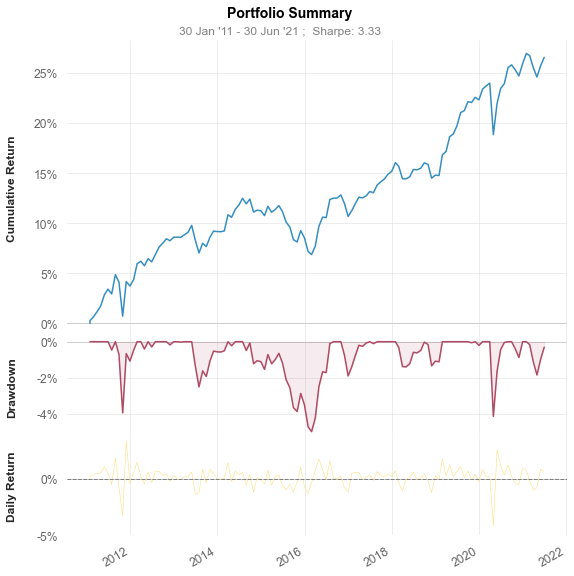

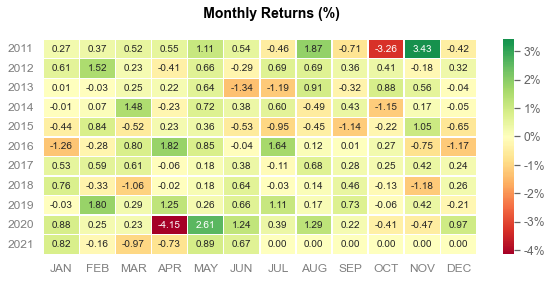

In [9]:
quantstats.reports.plots(month_rebal_strategy['strategy_return'], mode='basic')

In [10]:
quantstats.reports.metrics(returns=month_rebal_strategy['strategy_return'], benchmark=month_rebal_strategy['benchmark_return'],mode='full')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2011-01-31  2011-01-31
End Period                 2021-06-30  2021-06-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          26.59%      120.12%
CAGR﹪                     2.29%       7.87%

Sharpe                     3.34        5.94
Smart Sharpe               2.9         5.16
Sortino                    5.04        10.6
Smart Sortino              4.38        9.21
Sortino/√2                 3.56        7.5
Smart Sortino/√2           3.1         6.51
Omega                      1.83        1.83

Max Drawdown               -5.0%       -6.86%
Longest DD Days            731         488
Volatility (ann.)          14.42%      27.26%
R^2                        0.59        0.59
Calmar                     0.46        1.15
Skew                       -0.81       -0.31
Kurtosis                   5.79        0.

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2011-01-31  2011-01-31
End Period                 2021-06-30  2021-06-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          26.59%      120.12%
CAGR﹪                     2.29%       7.87%

Sharpe                     3.34        5.94
Smart Sharpe               2.9         5.16
Sortino                    5.04        10.6
Smart Sortino              4.38        9.21
Sortino/√2                 3.56        7.5
Smart Sortino/√2           3.1         6.51
Omega                      1.83        1.83

Max Drawdown               -5.0%       -6.86%
Longest DD Days            731         488
Volatility (ann.)          14.42%      27.26%
R^2                        0.59        0.59
Calmar                     0.46        1.15
Skew                       -0.81       -0.31
Kurtosis                   5.79        0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2014-08-31,2016-02-29,2016-08-31,731,-4.995064,-4.729288
2,2020-04-30,2020-04-30,2020-08-31,123,-4.149063,-1.648961
3,2011-09-30,2011-10-31,2012-02-29,152,-3.951366,-1.079201
4,2013-06-30,2013-07-31,2014-03-31,274,-2.510316,-1.933393
5,2016-11-30,2016-12-31,2017-06-30,212,-1.903492,-1.380133


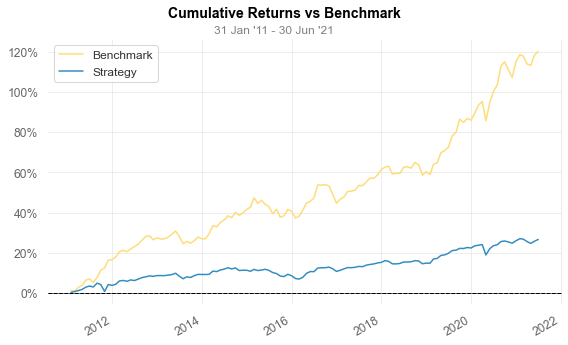

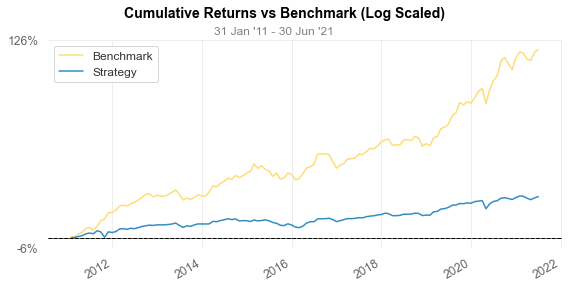

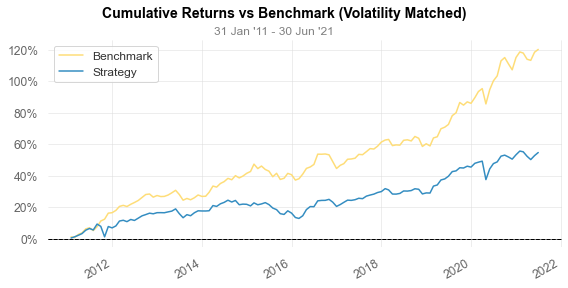

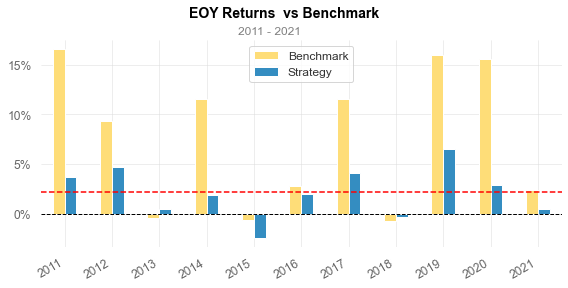

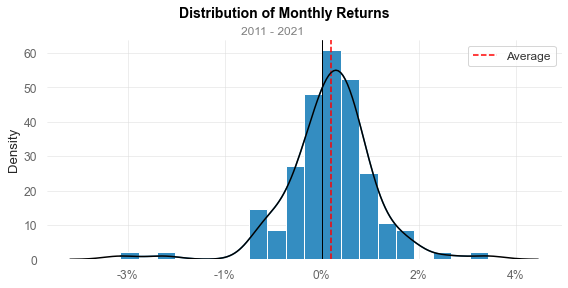

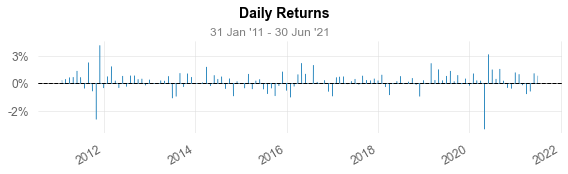

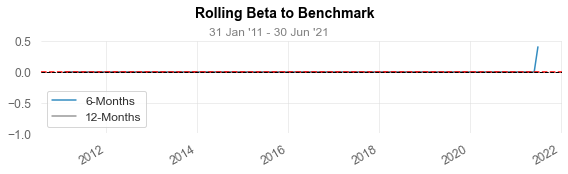

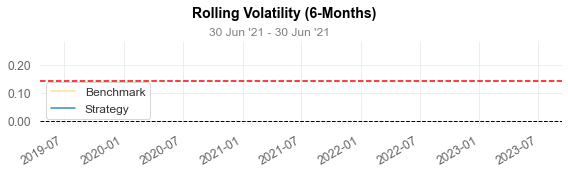

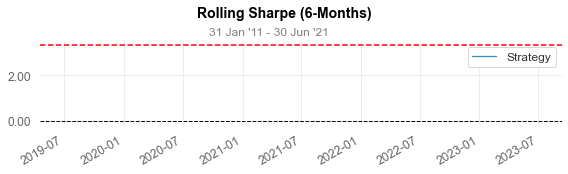

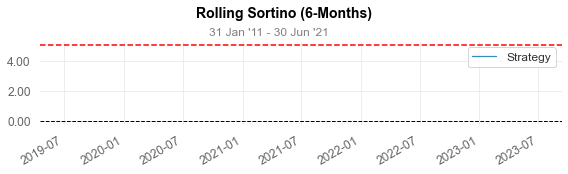

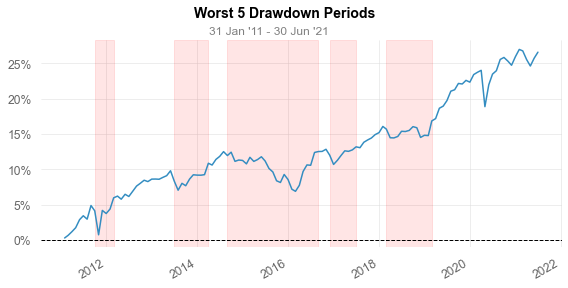

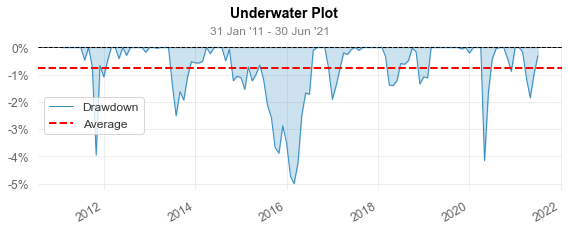

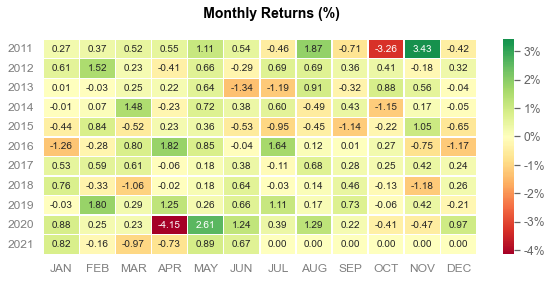

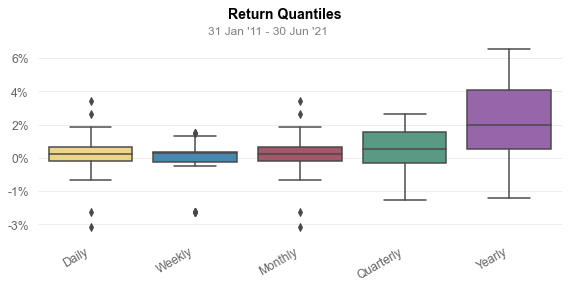

In [11]:
quantstats.reports.full(returns=month_rebal_strategy['strategy_return'], benchmark=month_rebal_strategy['benchmark_return'])